In [1]:
# 解释xgboost模型
# 需安装pydot、shap、graphviz包，pip install 包名

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

import shap


In [2]:
#%% 读取数据
df_train = pd.read_csv('data/df_train.csv',index_col=[0,1])
df_valid = pd.read_csv('data/df_valid.csv',index_col=[0,1])
df_test = pd.read_csv('data/df_test.csv',index_col=[0,1])

# 填补缺失值
df_train = df_train.fillna(0)
df_valid = df_valid.fillna(0)
df_test = df_test.fillna(0)


In [3]:
params = {
    'eta':0.1, # 学习速率
    'max_depth':3, # 最大树深
    'subsample':0.5, # 行采样比例
    'colsample_bynode':0.5, # 列采样比例
    'num_boost_round':1000, # 最多迭代多少轮
    'early_stopping_rounds':50, # 早停
    'verbose_eval':20, # 每隔多少轮迭代输出结果
    'save_path':'./results', # 模型存储路径
}


In [4]:
x_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1]
x_valid, y_valid = df_valid.iloc[:,:-1], df_valid.iloc[:,-1]

# xgboost need 1D array as its label
if y_train.values.ndim == 1:
    y_train_1d, y_valid_1d = y_train, y_valid
elif y_train.values.ndim == 2 and y_train.values.shape[1] == 1:
    y_train_1d, y_valid_1d = np.squeeze(y_train.values), np.squeeze(y_valid.values)
else:
    raise ValueError("XGBoost doesn't support multi-label training")

dtrain = xgb.DMatrix(x_train, label=y_train_1d)
dvalid = xgb.DMatrix(x_valid, label=y_valid_1d)
model = xgb.train(
    params,
    dtrain=dtrain,
    num_boost_round=params['num_boost_round'],
    early_stopping_rounds=params['early_stopping_rounds'],
    verbose_eval=params['verbose_eval'],
    evals=[(dtrain, "train"), (dvalid, "valid")],
    evals_result=dict(),
)


[23:56:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round", "save_path", "verbose_eval" } are not used.

[0]	train-rmse:1.09244	valid-rmse:1.09126
[20]	train-rmse:0.99801	valid-rmse:0.99766
[40]	train-rmse:0.99612	valid-rmse:0.99638
[60]	train-rmse:0.99571	valid-rmse:0.99658
[80]	train-rmse:0.99536	valid-rmse:0.99669
[83]	train-rmse:0.99531	valid-rmse:0.99667


In [5]:
x_test = df_test.iloc[:,:-1]
pred = pd.Series(model.predict(xgb.DMatrix(x_test)), index=x_test.index)
pred


datetime    instrument
2020-12-25  SH600000      0.032872
            SH600004     -0.004759
            SH600009      0.011782
            SH600010     -0.061098
            SH600011      0.019921
                            ...   
2021-06-30  SZ300595      0.026759
            SZ300601     -0.067221
            SZ300628      0.006744
            SZ300676      0.039406
            SZ300677     -0.028974
Length: 36900, dtype: float32

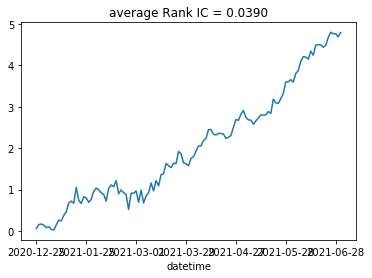

In [6]:
def calc_ic(pred: pd.Series, label: pd.Series, date_col="datetime", dropna=False):
    """calc_ic.

    Parameters
    ----------
    pred :
        pred
    label :
        label
    date_col :
        date_col

    Returns
    -------
    (pd.Series, pd.Series)
        ic and rank ic
    """
    df = pd.DataFrame({"pred": pred, "label": label})
    ic = df.groupby(date_col).apply(lambda df: df["pred"].corr(df["label"]))
    ric = df.groupby(date_col).apply(lambda df: df["pred"].corr(df["label"], method="spearman"))
    if dropna:
        return ic.dropna(), ric.dropna()
    else:
        return ic, ric

ic, ric = calc_ic(pred, df_test.iloc[:,-1], dropna=True)

# 绘制累计Rank IC
ric.cumsum().plot(title='average Rank IC = %.4f'%ric.mean())


In [7]:
# 代理决策树
# importance_type: weight gain cover total_gain total_cover
score = pd.Series(model.get_score(importance_type='gain')).sort_values(ascending=False)
score


x7    12.603851
x5    10.432032
x9    10.246890
x0    10.170173
x3     8.916460
x1     8.688936
x4     8.250552
x2     8.085629
x6     7.964481
x8     7.877000
dtype: float64

[23:56:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round", "save_path", "verbose_eval" } are not used.



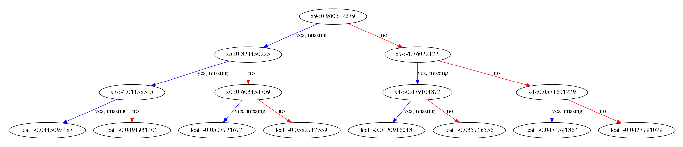

In [8]:
# 代理决策树
x = df_train.iloc[:,:-1] 
# x = df_test.iloc[:,:-1]
y_pred = pd.Series(model.predict(xgb.DMatrix(x)), index=x.index) 

dtrain = xgb.DMatrix(x, label=y_pred)
SDT = xgb.train(
    params,
    dtrain=dtrain,
    num_boost_round=1,
)

fig, ax = plt.subplots(figsize=(12,12))
ax = xgb.plot_tree(SDT,num_trees=0, ax=ax)
plt.savefig(params['save_path']+'/explainer_sdt.png',dpi=1200)


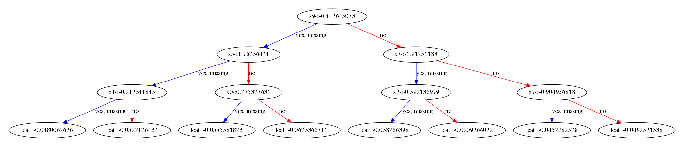

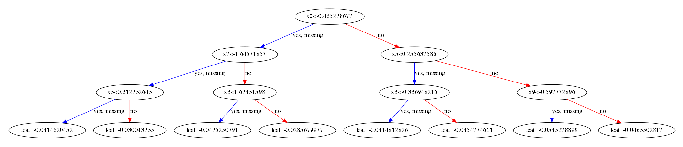

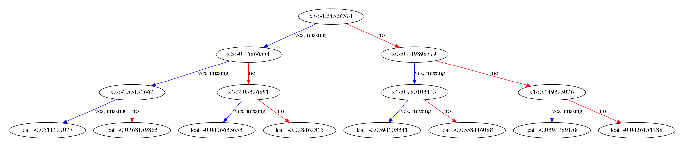

In [9]:
# 指定树
num_trees_list = [0,1,2]
for num_trees in num_trees_list:
    fig, ax = plt.subplots(figsize=(12,12))
    ax = xgb.plot_tree(model,num_trees=num_trees, ax=ax)
    plt.savefig(params['save_path']+'/explainer_tree_%d.png'%(num_trees),dpi=1200)


In [10]:
# PDP
feature_names = df_train.columns[:-1]
os.makedirs(params['save_path']+'/explainer_pdp/',exist_ok=True)

for feature in feature_names:
    
    x = df_train.iloc[:,:-1].copy()
    #x = df_test.iloc[:,:-1].copy()

    # 计算PDP时，因子取值范围为-5:0.2:5
    x_range = np.arange(np.floor(min(x.loc[:,feature])),
                        np.ceil(max(x.loc[:,feature])),
                        0.2)

    # 初始化
    pdp = np.zeros_like(x_range)
    # 计算PDP
    for i, c in enumerate(x_range):
        x.loc[:,feature] = c
        pdp[i] = model.predict(xgb.DMatrix(x)).mean()

    # 绘制PDP
    plt.figure()
    plt.plot(x_range,pdp)
    plt.title('PDP of %s'%(feature))
    plt.xlabel('%s'%(feature))
    plt.ylabel('y')
    plt.savefig(params['save_path']+'/explainer_pdp/explainer_pdp_%s.png'%(feature))
    plt.close()


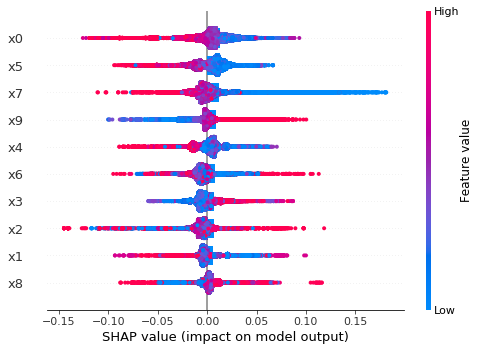

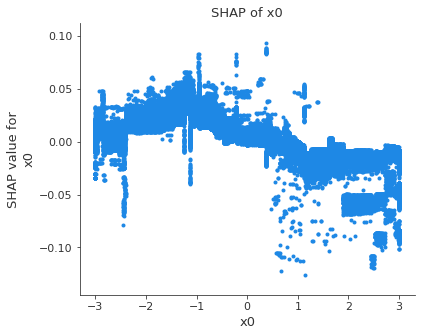

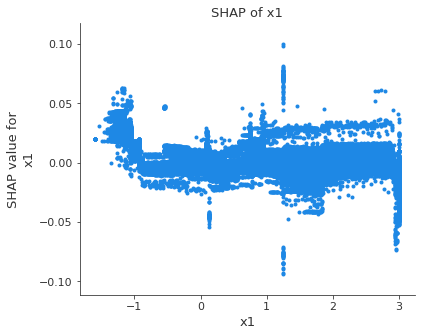

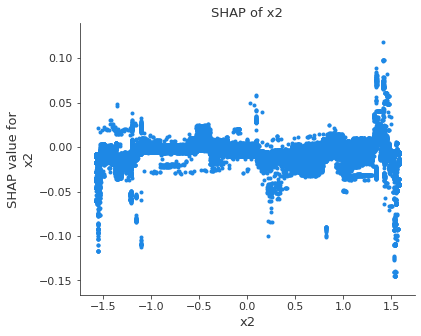

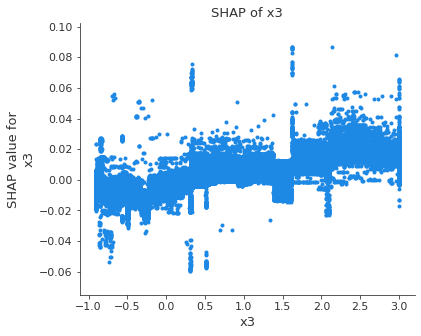

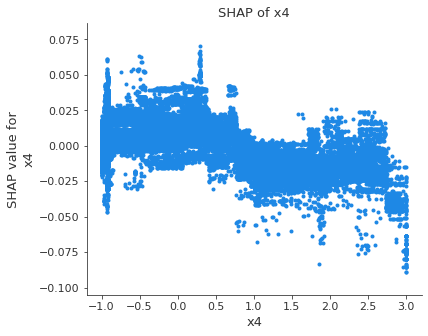

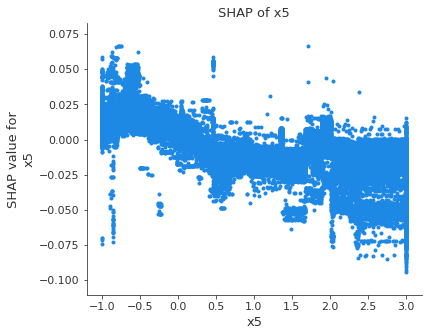

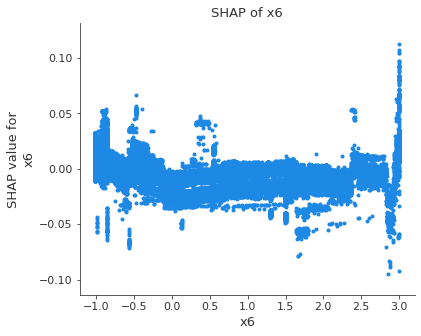

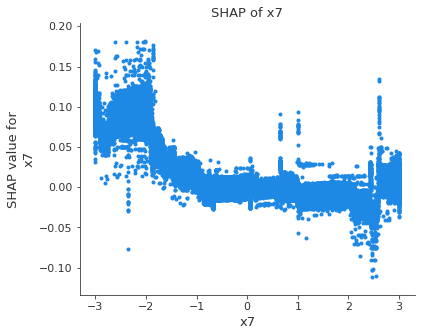

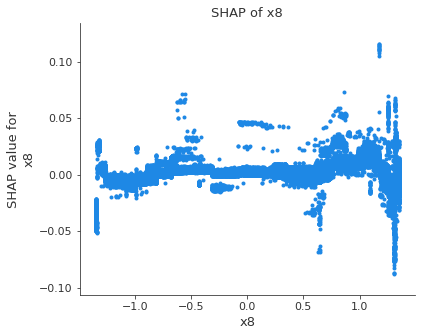

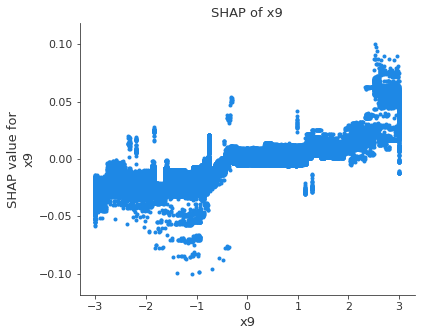

In [11]:
# 定义计算SHAP模型，这里使用TreeExplainer
explainer = shap.TreeExplainer(model)

x = df_train.iloc[:,:-1].copy()
#x = df_test.iloc[:,:-1].copy()
feature_names = df_train.columns[:-1]

# 计算全部因子SHAP
shap_values = explainer.shap_values(x)
os.makedirs(params['save_path']+'/explainer_shap/',exist_ok=True)

# 全部特征SHAP柱状图
shap.summary_plot(shap_values,x,plot_type='bar',title='|SHAP|',show=False)
plt.savefig(params['save_path']+'/explainer_shap/explainer_shap_bar.png',dpi=100,bbox_inches='tight')

# 全部特征SHAP点图
shap.summary_plot(shap_values,x,plot_type='dot',title='SHAP',show=False)
plt.savefig(params['save_path']+'/explainer_shap/explainer_shap_dot.png',dpi=100,bbox_inches='tight')

# 单个特征SHAP点图
for feature in feature_names:
    shap.dependence_plot(feature,shap_values,x,interaction_index=None,title='SHAP of %s'%(feature),show=False)
    plt.savefig(params['save_path']+'/explainer_shap/explainer_shap_dot_%s.png'%(feature),dpi=100,bbox_inches='tight')
